In [ ]:
#!pip install pmdarima sfrancia arch scipy

  Using cached Cython-3.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 30.3 MB/s eta 0:00:00
Using cached Cython-3.0.11-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)


In [49]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import AutoARIMA
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tsai.all import *
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
import optuna
import seaborn as sns
from scipy.stats import shapiro, kstest, jarque_bera
from statsmodels.stats.stattools import durbin_watson
from sfrancia import shapiroFrancia
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
import scipy.stats as stats
from matplotlib.gridspec import GridSpec
import scipy.stats as stats


class optuna_optimize:
    def __init__(self,arch,X,y,splits,epochs):
        self.arch = arch
        self.X = X
        self.y = y
        self.splits = splits
        self.epochs = epochs

    def optuna_objective(self,trial):
        hidden_size = trial.suggest_int('hidden_size', 16, 200)
        n_layers = trial.suggest_int('n_layers', 1, 5)
        rnn_dropout = trial.suggest_float('rnn_dropout', 0, 0.8)
        bidirectional = trial.suggest_categorical('bidirectional', [True, False])
        fc_dropout = trial.suggest_float('fc_dropout', 0, 0.8)
        learning_rate_model = trial.suggest_float('learning_rate_model', 1e-5, 1e-1,log=True)

        arch_config ={
            'hidden_size': hidden_size,
            'n_layers': n_layers,
            'rnn_dropout': rnn_dropout,
            'bidirectional': bidirectional,
            'fc_dropout': fc_dropout,
        }
        tfms = [None, TSForecasting()]
        learn = TSForecaster(self.X, self.y, splits=self.splits, path='models', tfms=tfms,
                            batch_tfms=TSStandardize(),
                            arch=self.arch, arch_config=arch_config,
                            cbs=[
                                ReduceLROnPlateau(patience=3), EarlyStoppingCallback(patience=5)
                            ],seed=1)
        
        with ContextManagers([learn.no_bar(),learn.no_logging()]):
            learn.fit_one_cycle(self.epochs, lr_max=learning_rate_model)
        
        return learn.recorder.values[-1][-1]



def forecast_arima(series, new_data, seasonal=False, m=1, arima_model=None,
                    start_p=4, start_q=0, d=None, max_p=10, max_q=10, max_d=3, max_order=None,
                    start_P=1, start_Q=1, D=None, max_P=8, max_Q=8, max_D=1):
    
    if not arima_model:
        arima_model = AutoARIMA(start_p=start_p, d=d, start_q=start_q, max_p=max_p, max_d=max_d,
                                max_q=max_q, max_order=max_order, start_P=start_P, D=D, start_Q=start_Q,
                                max_P=max_P, max_D=max_D, max_Q=max_Q, seasonal=seasonal, m=m,
                                trace=True, error_action='ignore', suppress_warnings=True,
                                stepwise=True, information_criterion='bic', scoring='mse',
                                with_intercept='auto')
        
    arima_model = arima_model.fit(y=series)
    lista_previsoes = []
    for j in range(new_data.shape[0]):
        janela_8_dias = new_data[j, 0]
        previsao = arima_model.predict(n_periods=8)
        lista_previsoes.append(previsao)
        arima_model = arima_model.update(janela_8_dias)

    forecast = np.array(lista_previsoes)
    return arima_model, forecast

def forecast_exponential_smoothing(series, new_data, trend='add', seasonal='add', seasonal_periods=7,
                                    initialization_method='heuristic', use_boxcox=False):
    model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods,
                                    initialization_method=initialization_method, use_boxcox=use_boxcox)
    model_fit = model.fit()

    lista_previsoes = []
    for j in range(new_data.shape[0]):
        previsao = model_fit.forecast(steps=8)
        lista_previsoes.append(previsao)
        series = np.concatenate([series, new_data[j, 0]])
        model = ExponentialSmoothing(series, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods,
                                        initialization_method=initialization_method)
        model_fit = model.fit()

    forecast = np.array(lista_previsoes)
    return model_fit, forecast

def forecast_ann(X, y,splits,model = LSTMPlus, epochs=100,arch_config={},btfms=TSStandardize(),loss_func=nn.MSELoss(),cbs=[],lr = None):
    learn = TSForecaster(X, y,splits=splits, arch=model, metrics=[mae, rmse],arch_config=arch_config, batch_tfms=btfms, tfms=[None, [TSForecasting()]], loss_func=loss_func) # type: ignore
    with ContextManagers([learn.no_logging(), learn.no_bar()]):
        if not lr:
            lr = learn.lr_find() # Achar o melhor learning rate pro modelo, método da biblioteca fastai
            learn.fit_one_cycle(epochs, lr_max=lr.valley, cbs=cbs) # Treinar o modelo
        else:
            learn.fit_one_cycle(epochs, lr_max=lr, cbs=cbs)
        print(f'Métricas de Treinamento para {model}')
        display(pd.Series(learn.recorder.values[-1], index=learn.recorder.metric_names[1:5]))
        raw_preds, target, _ = learn.get_X_preds(X[splits[2]],y[splits[2]])
        return raw_preds,target



def decompose_series(series):
    decomposed = STL(series).fit()
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    resid = decomposed.resid
    #decomposed.plot()
    fig, axs = plt.subplots(4, 1, figsize=(14, 8))
    axs[0].plot(series)
    axs[0].set_title('Original Series')
    axs[1].plot(trend)
    axs[1].set_title('Trend')
    axs[2].plot(seasonal)
    axs[2].set_title('Seasonal')
    axs[3].scatter(series.index,resid)
    axs[3].set_title('Residual')
    plt.tight_layout()
    plt.savefig('decomposed.png')
    plt.show()
    return trend, seasonal, resid


def load_and_prepare_data(filepath):
    peru = pd.read_csv(filepath, index_col='index').rename(columns={'GPP': 'peru'})
    peru.index = pd.to_datetime(peru.index)
    peru = peru.resample('D').mean()
    return peru


def plot_boxplot(forecast1, forecast2, target1, target2, dt_index):
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    df_residuals = pd.DataFrame({
        'Residuals STL-ARIMA-ES-LSTM': preds_residuals1,
        'Residuals LSTM': preds_residuals2
    }, index=dt_index)
    df_residuals.to_csv('residuals.csv')


    df_residuals_melted = df_residuals.melt(var_name='Model', value_name='Residuals')

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df_residuals_melted, x='Model', y='Residuals', ax=ax, width=0.6)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=1, label=None)
    ax.set_title('Box Plot of Residuals')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Model')

    plt.tight_layout()
    plt.savefig('boxplot_comparison.png')
    plt.show()


def acf(forecast1, forecast2, target1, target2):
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    def plot_acf_custom(ax, residuals, title):
        sm.graphics.tsa.plot_acf(residuals, ax=ax)
        ax.set_title(title)

    plot_acf_custom(axs[0], preds_residuals1, 'Autocorrelation of Residuals (STL-ARIMA-ES-LSTM) (a)')
    plot_acf_custom(axs[1], preds_residuals2, 'Autocorrelation of Residuals (LSTM) (b)')

    plt.tight_layout()
    plt.savefig('acf.png')
    plt.show()

def plot_qq_hist_kde(forecast1, forecast2, target1, target2):
    preds_residuals1 = forecast1 - target1
    preds_residuals2 = forecast2 - target2

    fig, axs = plt.subplots(2, 2, figsize=(13, 9))

    def plot_qq(ax, residuals, title):
        residuals = stats.zscore(residuals)
        sm.qqplot(residuals, line='s', ax=ax)
        ax.set_title(title)

    plot_qq(axs[0, 0], preds_residuals1, 'Q-Q Plot of Residuals (STL-ARIMA-ES-LSTM) (a)')
    plot_qq(axs[0, 1], preds_residuals2, 'Q-Q Plot of Residuals (LSTM) (b)')

    def plot_hist(ax, residuals, title):
        residuals_norm = stats.zscore(residuals)
        sns.histplot(x=residuals_norm, kde=True, ax=ax, stat='density', linewidth=0, bins=20)
        x_min, x_max = ax.get_xlim()
        x_axis = np.linspace(x_min, x_max, 100)
        normal_curve = stats.norm.pdf(x_axis, np.mean(residuals_norm), np.std(residuals_norm))
        ax.plot(x_axis, normal_curve, color='red', linestyle='--', linewidth=2, label='Normal Distribution')
        ax.set_title(title)
        ax.legend()

    plot_hist(axs[1, 0], preds_residuals1, 'Histogram with KDE of Normalized Residuals (STL-ARIMA-ES-LSTM) (c)')
    plot_hist(axs[1, 1], preds_residuals2, 'Histogram with KDE of Normalized Residuals (LSTM) (d)')

    plt.tight_layout()
    plt.savefig('qq_hist_kde.png')
    plt.show()
    


    print('Resumo dos resíduos do modelo STL-ARIMA-ES-LSTM:')
    hyp_tests(preds_residuals1)
    print('====================================================================================================')
    print('Resumo dos resíduos do modelo LSTM:')
    hyp_tests(preds_residuals2)


def residual_general_summary(forecast1, forecast2, target1, target2, dt_index):
    sns.set_style('darkgrid')
    plot_qq_hist_kde(forecast1, forecast2, target1, target2)
    acf(forecast1, forecast2, target1, target2)
    plot_boxplot(forecast1, forecast2, target1, target2, dt_index)



def residual_summary(forecast, target, dt_index):
    sns.set_style('darkgrid')
    preds_residuals = forecast - target
    residuos = pd.Series(data=preds_residuals, index=dt_index)
    display(residuos)
    print(residuos.describe())

    # Configuração do layout dos subplots
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 15))

    # Residuals vs Fitted Values plot
    axes[0, 0].scatter(forecast, preds_residuals)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_title('Residuals vs Fitted Values')

    # Q-Q plot of residuals to check normality
    sm.qqplot(preds_residuals, line='s', ax=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot of Residuals')

    # Histogram of residuals
    sns.histplot(x=preds_residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Histogram with KDE of Residuals')

    # Autocorrelation plot of residuals
    plot_acf(preds_residuals, ax=axes[1, 1])
    axes[1, 1].set_title('Autocorrelation of Residuals')

    # Residuals vs Time
    axes[2, 0].plot(preds_residuals)
    axes[2, 0].axhline(0, color='red', linestyle='--')
    axes[2, 0].set_title('Residuals over Time')

    # Remove the last empty subplot
    sns.boxplot(x=preds_residuals, ax=axes[2, 1])
    axes[2, 1].set_title('Boxplot of Residuals')

    plt.tight_layout()
    plt.show()

def hyp_tests(residuos):
    shap = shapiro(residuos)
    shapiro_pvalue = shap[1]
    if shapiro_pvalue > 0.05:
        shapiro_interpretation = "Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05)."
    else:
        shapiro_interpretation = "Rejeitamos a hipótese nula de que os resíduos seguem uma distribuição normal (p <= 0.05)."

    kstest_pvalue = kstest(residuos, 'norm')[1]
    if kstest_pvalue > 0.05:
        kstest_interpretation = "Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05)."
    else:
        kstest_interpretation = "Rejeitamos a hipótese nula de que os resíduos seguem uma distribuição normal (p <= 0.05)."

    durbin_watson_stat = durbin_watson(residuos)
    if durbin_watson_stat < 1.5 or durbin_watson_stat > 2.5:
        durbin_watson_interpretation = "Possível autocorrelação nos resíduos (Durbin-Watson fora do intervalo 1.5-2.5)."
    else:
        durbin_watson_interpretation = "Não há evidência de autocorrelação nos resíduos (Durbin-Watson dentro do intervalo 1.5-2.5)."

    shapiro_francia_pvalue = shapiroFrancia(residuos)['p-value']
    if shapiro_francia_pvalue > 0.05:
        shapiro_francia_interpretation = "Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05)."
    else:
        shapiro_francia_interpretation = "Rejeitamos a hipótese nula de que os resíduos seguem uma distribuição normal (p <= 0.05)."

    # Teste Ljung-Box para autocorrelação residual
    lb_pvalue = acorr_ljungbox(residuos)
    if np.any(lb_pvalue.values < 0.05):
        lb_interpretation = "Evidência significativa de autocorrelação nos resíduos."
    else:
        lb_interpretation = "Não há evidência significativa de autocorrelação nos resíduos."

    # Teste Jarque-Bera para normalidade dos resíduos
    jb_pvalue = jarque_bera(residuos)
    if jb_pvalue.pvalue < 0.05:
        jb_interpretation = "Os resíduos não seguem uma distribuição normal."
    else:
        jb_interpretation = "Os resíduos seguem uma distribuição normal."

    # Teste ARCH para heterocedasticidade condicional
    model_arch = arch_model(residuos)
    result = model_arch.fit(disp='off')
    arch_lm_test = result.arch_lm_test()
    arch_lm_pvalue = arch_lm_test.pval
    if arch_lm_pvalue < 0.05:
        arch_lm_interpretation = "Há evidência de heterocedasticidade condicional nos resíduos."
    else:
        arch_lm_interpretation = "Não há evidência de heterocedasticidade condicional nos resíduos."

    print("\nResumo das análises estatísticas:")
    print("Shapiro-Wilk Test p-value:", shapiro_pvalue, "-", shapiro_interpretation)
    print("Kolmogorov-Smirnov Test p-value:", kstest_pvalue, "-", kstest_interpretation)
    print("Durbin-Watson Statistic:", durbin_watson_stat, "-", durbin_watson_interpretation)
    print("Shapiro-Francia Test p-value:", shapiro_francia_pvalue, "-", shapiro_francia_interpretation)
    print("Ljung-Box Test p-value:", lb_pvalue, "-", lb_interpretation)
    print("Jarque-Bera Test p-value:", jb_pvalue.pvalue, "-", jb_interpretation)
    print("ARCH LM Test p-value:", arch_lm_pvalue, "-", arch_lm_interpretation)

def Default_LSTM(peru):

    indice_divisivel_por_oito = peru.shape[0] - (peru.shape[0] % 8)
    peru = peru.iloc[:indice_divisivel_por_oito]
    peru_splits = get_walk_forward_splits(peru.values.reshape(int(peru.shape[0] / 8),1,8),valid_size=0.15,test_size=0.15,anchored=True,n_splits=3)

    final_predictions = []
    real_values_list = []
    index_list = []

    for split in peru_splits:
        train = peru.iloc[split[0]]
        val = peru.iloc[split[1]]
        test = peru.iloc[split[2]]

        peru_dados = pd.concat([train, val, test], axis=0)

        percent_val = len(split[1]) /(len(split[0]) + len(split[1]) + len(split[2]))
        percent_test = len(split[2]) /(len(split[0]) + len(split[1]) + len(split[2]))


        peru_dados_x, peru_dados_y = SlidingWindow(window_len=8, horizon=8, stride=None)(peru_dados.values)

        optuna_opt = optuna_optimize(LSTMPlus,peru_dados_x,peru_dados_y,split,epochs=500)
        study = optuna.create_study(direction='minimize')
        study.optimize(optuna_opt.optuna_objective, n_trials=200)
        
        arch_config = study.best_params

        arch_config_without_lr = {key: value for key, value in arch_config.items() if key != 'learning_rate_model'}
        lr = study.best_params['learning_rate_model']

        splits_peru = TSSplitter(valid_size=percent_val,test_size=percent_test,show_plot=False)(peru_dados_y)


        peru_forecast, target_peru = forecast_ann(peru_dados_x, peru_dados_y, splits_peru, model=LSTMPlus, epochs=500,
                                                        arch_config=arch_config_without_lr, lr= lr,
                                                        btfms=TSStandardize(),loss_func=HuberLoss('mean'),cbs=[ReduceLROnPlateau(patience=3),EarlyStoppingCallback(patience=5)],
                                                        )
        final_predictions.extend(peru_forecast.numpy().flatten())
        real_values_list.extend(target_peru.numpy().flatten())

        indices = peru['peru'][peru['peru'].isin(peru_dados_y[splits_peru[2]].flatten())]
        index_list.extend(indices.index)

    final_predictions = np.array(final_predictions)
    real_values_list = np.array(real_values_list)
    index_list = np.array(index_list)

    rmse = mean_squared_error(real_values_list, final_predictions, squared=False)
    mae = mean_absolute_error(real_values_list, final_predictions)
    r2 = r2_score(real_values_list, final_predictions)
    mape = mean_absolute_percentage_error(real_values_list, final_predictions)
    corr = np.corrcoef(real_values_list, final_predictions)[0, 1]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")
    print(f"MAPE: {mape}")
    print(f"Correlação Linear: {corr}")

    return final_predictions, real_values_list, index_list



def STL_ARIMA_ES_LSTM(peru):
    indice_divisivel_por_oito = peru.shape[0] - (peru.shape[0] % 8)
    peru = peru.iloc[:indice_divisivel_por_oito]

    peru_splits = get_walk_forward_splits(peru.values.reshape(int(peru.shape[0] / 8),1,8),valid_size=0.15,test_size=0.15,anchored=True,n_splits=3)

    final_predictions = []
    real_values_list = []

    for split in peru_splits:
        train = peru.iloc[split[0]]
        val = peru.iloc[split[1]]
        test = peru.iloc[split[2]]

        trend_train, seasonal_train, resid_train = decompose_series(train)
        trend_val, seasonal_val, resid_val = decompose_series(val)
        trend_test, seasonal_test, resid_test = decompose_series(test)

        resid = pd.concat([resid_train, resid_val, resid_test], axis=0)

        resid_x, resid_y = SlidingWindow(window_len=8, horizon=8, stride=None)(resid.values)

        percent_val = len(split[1]) /(len(split[0]) + len(split[1]) + len(split[2]))
        percent_test = len(split[2]) /(len(split[0]) + len(split[1]) + len(split[2]))

        splits_resid = TSSplitter(valid_size=percent_val,test_size=percent_test,show_plot=False)(resid_y)
        optuna_opt = optuna_optimize(LSTMPlus,resid_x,resid_y,splits_resid,epochs=500)
        study = optuna.create_study(direction='minimize')
        study.optimize(optuna_opt.optuna_objective, n_trials=200)

        arch_config = study.best_params

        arch_config_without_lr = {key: value for key, value in arch_config.items() if key != 'learning_rate_model'}
        lr = study.best_params['learning_rate_model']


        residual_forecast,target_residual = forecast_ann(resid_x, resid_y,splits_resid,model=LSTMPlus, epochs=500,
                                                        arch_config=arch_config_without_lr, lr= lr,
                                                        btfms=TSStandardize(),loss_func=HuberLoss('mean'),
                                                        cbs=[ReduceLROnPlateau(patience=3),EarlyStoppingCallback(patience=5)],
                                                        )
            
        train_trend = np.concatenate([trend_train,trend_val])
        arima_model, trend_forecast = forecast_arima(series=train_trend,new_data=trend_test.values.reshape(-1,1,8))

        train_seasonal = np.concatenate([seasonal_train,seasonal_val])
        es_model, seasonal_forecast = forecast_exponential_smoothing(series=train_seasonal,new_data=seasonal_test.values.reshape(-1,1,8),trend=None,seasonal_periods=7)

        final_pred = residual_forecast.flatten() + seasonal_forecast.flatten() + trend_forecast.flatten()
        real_values = target_residual.numpy().flatten() + trend_test + seasonal_test
        real_values = real_values.values
        final_pred = final_pred.numpy()
        final_predictions.extend(final_pred)
        real_values_list.extend(real_values)

    final_predictions = np.array(final_predictions)
    real_values_list = np.array(real_values_list)


    rmse = mean_squared_error(real_values_list, final_predictions, squared=False)
    mae = mean_absolute_error(real_values_list, final_predictions)
    r2 = r2_score(real_values_list, final_predictions)
    mape = mean_absolute_percentage_error(real_values_list, final_predictions)
    corr = np.corrcoef(real_values_list, final_predictions)[0, 1]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")
    print(f"MAPE: {mape}")
    print(f"Correlação Linear: {corr}")

    return final_predictions, real_values_list




def main():
    filepath = 'peru.csv'
    peru = load_and_prepare_data(filepath)
    print('====================================================================================================')
    print('STL + ARIMA + ES + LSTM')
    hybrid_forecast, target_hybrid = STL_ARIMA_ES_LSTM(peru=peru)
    print('====================================================================================================')
    print('Default LSTM')
    lstm_forecast, target_lstm, datetime = Default_LSTM(peru=peru)
    print('====================================================================================================')

    return hybrid_forecast, lstm_forecast, target_hybrid, target_lstm, datetime

STL + ARIMA + ES + LSTM


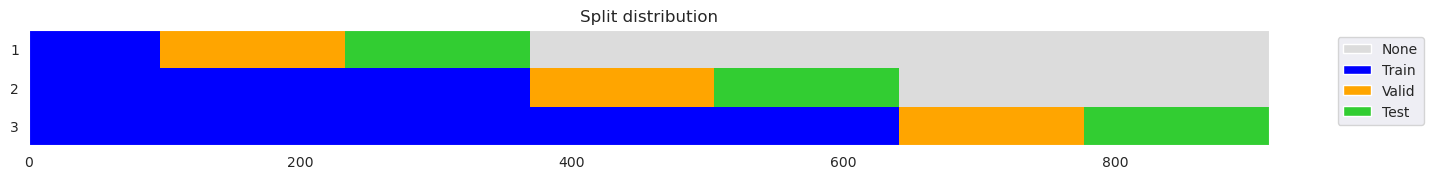

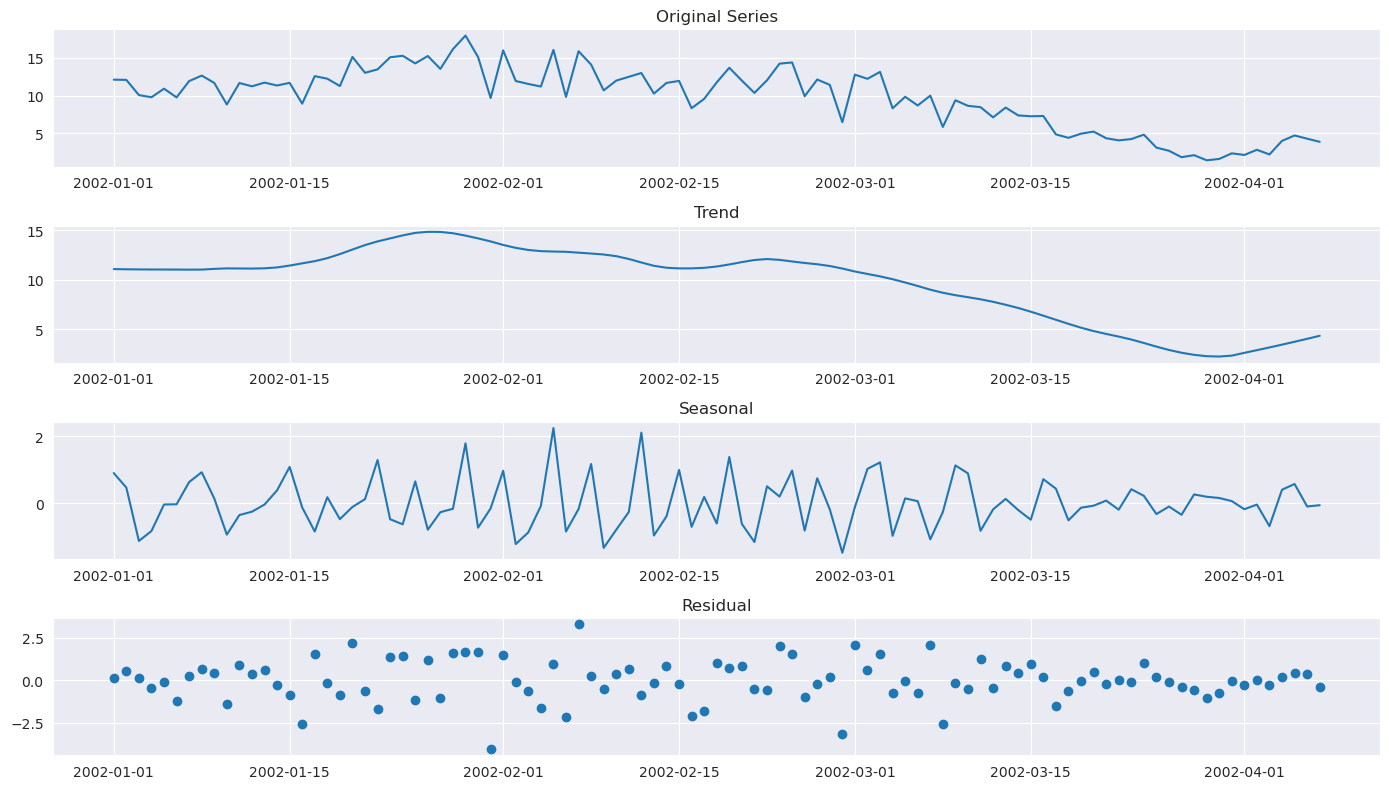

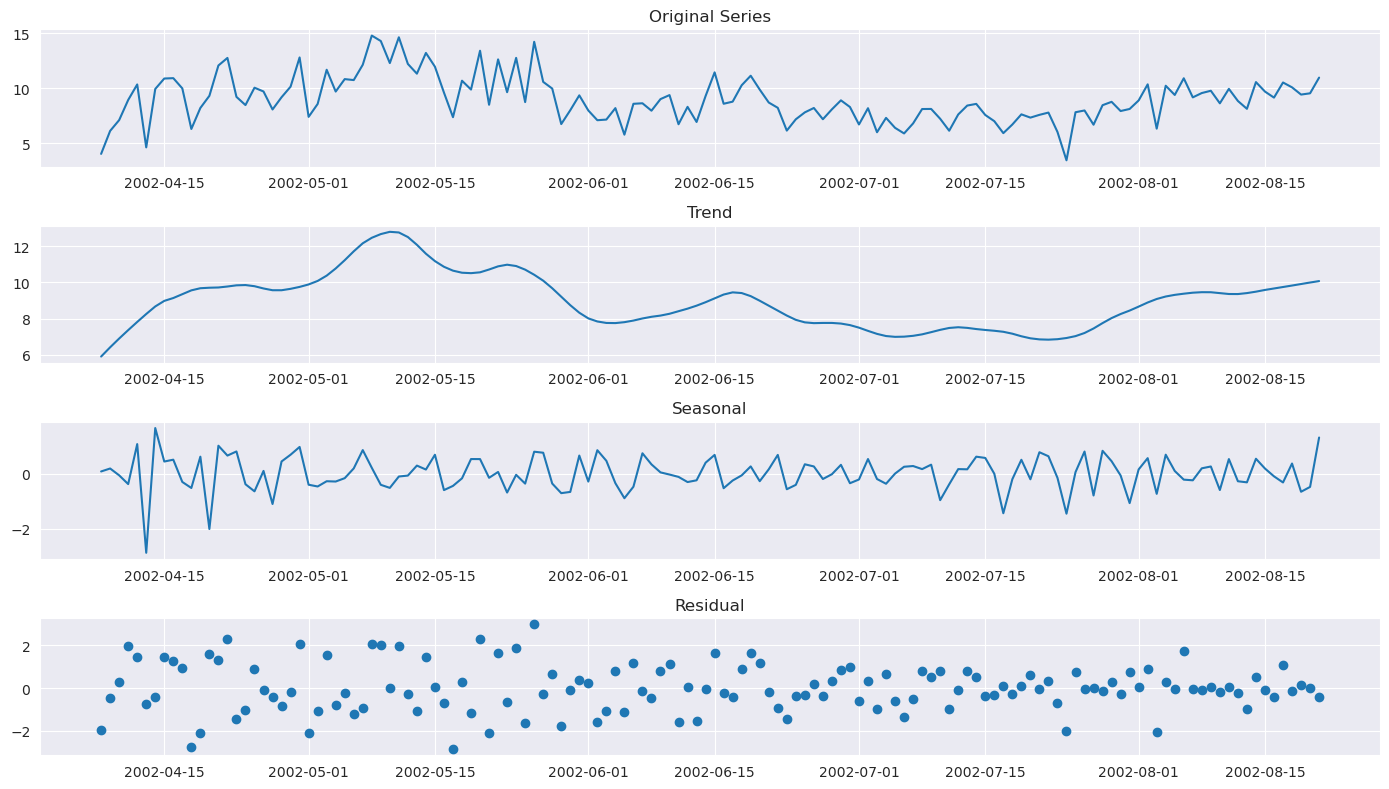

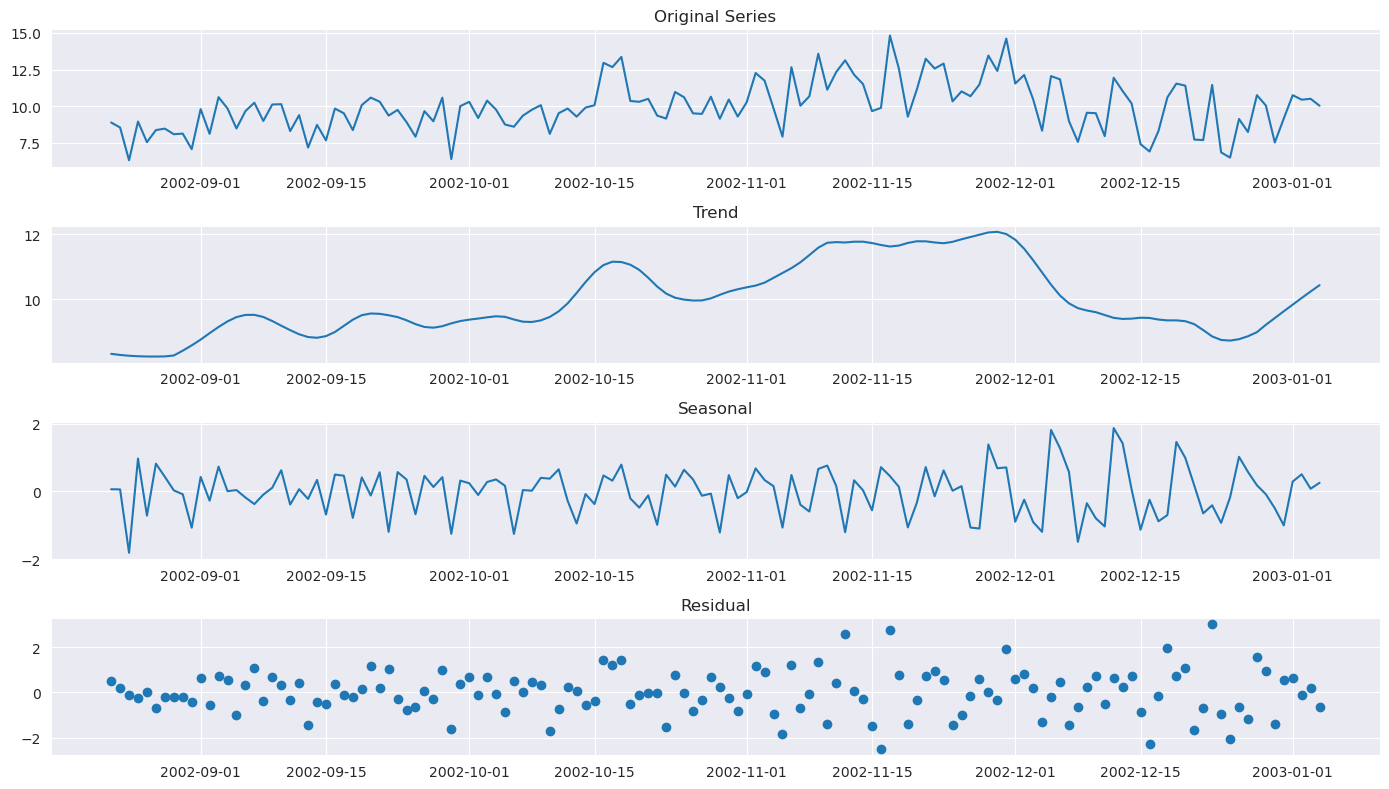

[I 2024-12-10 00:10:34,576] A new study created in memory with name: no-name-165849e1-7805-4330-bd7c-b4bf0deb75ea
[I 2024-12-10 00:10:36,707] Trial 0 finished with value: 1.2048463821411133 and parameters: {'hidden_size': 118, 'n_layers': 2, 'rnn_dropout': 0.3605330356052385, 'bidirectional': True, 'fc_dropout': 0.6639141666939987, 'learning_rate_model': 0.00011582228717141106}. Best is trial 0 with value: 1.2048463821411133.


Epoch 115: reducing lr to 1.1407567823210007e-05
No improvement since epoch 112: early stopping


[I 2024-12-10 00:10:37,122] Trial 1 finished with value: 1.2201204299926758 and parameters: {'hidden_size': 44, 'n_layers': 2, 'rnn_dropout': 0.3637766126224691, 'bidirectional': False, 'fc_dropout': 0.540996444148164, 'learning_rate_model': 0.0018816056663487645}. Best is trial 0 with value: 1.2048463821411133.


Epoch 40: reducing lr to 4.94491857231328e-05
No improvement since epoch 37: early stopping


[I 2024-12-10 00:10:37,332] Trial 2 finished with value: 1.2118350267410278 and parameters: {'hidden_size': 45, 'n_layers': 1, 'rnn_dropout': 0.4840967986033411, 'bidirectional': True, 'fc_dropout': 0.5677011971698888, 'learning_rate_model': 0.022678534797267867}. Best is trial 0 with value: 1.2048463821411133.


Epoch 16: reducing lr to 0.00017754733893721818
No improvement since epoch 13: early stopping


[I 2024-12-10 00:10:37,870] Trial 3 finished with value: 1.2215763330459595 and parameters: {'hidden_size': 146, 'n_layers': 5, 'rnn_dropout': 0.10733205425297135, 'bidirectional': True, 'fc_dropout': 0.30846970125851236, 'learning_rate_model': 0.00615735203663167}. Best is trial 0 with value: 1.2048463821411133.


Epoch 3: reducing lr to 2.546910342191358e-05
No improvement since epoch 0: early stopping


[I 2024-12-10 00:10:38,083] Trial 4 finished with value: 1.2238694429397583 and parameters: {'hidden_size': 124, 'n_layers': 5, 'rnn_dropout': 0.30671571913504164, 'bidirectional': False, 'fc_dropout': 0.7981151934048539, 'learning_rate_model': 0.009283051888088355}. Best is trial 0 with value: 1.2048463821411133.


Epoch 5: reducing lr to 4.064578996432809e-05
No improvement since epoch 2: early stopping


[I 2024-12-10 00:10:41,308] Trial 5 finished with value: 1.2026053667068481 and parameters: {'hidden_size': 148, 'n_layers': 1, 'rnn_dropout': 0.13136068427620504, 'bidirectional': True, 'fc_dropout': 0.03662032522486269, 'learning_rate_model': 3.5573226103130156e-05}. Best is trial 5 with value: 1.2026053667068481.


Epoch 283: reducing lr to 2.2137897008360433e-06
No improvement since epoch 280: early stopping


[I 2024-12-10 00:10:43,756] Trial 6 finished with value: 1.221895694732666 and parameters: {'hidden_size': 160, 'n_layers': 4, 'rnn_dropout': 0.794949097532488, 'bidirectional': True, 'fc_dropout': 0.5191960491843822, 'learning_rate_model': 3.203978547826209e-05}. Best is trial 5 with value: 1.2026053667068481.
[I 2024-12-10 00:10:43,851] Trial 7 finished with value: 1.2209932804107666 and parameters: {'hidden_size': 37, 'n_layers': 4, 'rnn_dropout': 0.5528576447515182, 'bidirectional': False, 'fc_dropout': 0.04180644287273978, 'learning_rate_model': 0.0019988762367512043}. Best is trial 5 with value: 1.2026053667068481.


Epoch 63: reducing lr to 1.6853943186960272e-06
No improvement since epoch 60: early stopping
Epoch 3: reducing lr to 8.268097275995853e-06
No improvement since epoch 0: early stopping


[I 2024-12-10 00:10:46,597] Trial 8 finished with value: 1.218177318572998 and parameters: {'hidden_size': 86, 'n_layers': 4, 'rnn_dropout': 0.2541459225421045, 'bidirectional': True, 'fc_dropout': 0.574710807693817, 'learning_rate_model': 7.565029436038891e-05}. Best is trial 5 with value: 1.2026053667068481.


Epoch 110: reducing lr to 7.310032799362578e-06
No improvement since epoch 107: early stopping
Epoch 6: reducing lr to 0.00013702985132885633


[I 2024-12-10 00:10:46,780] Trial 9 finished with value: 1.2342188358306885 and parameters: {'hidden_size': 139, 'n_layers': 3, 'rnn_dropout': 0.5346867566711676, 'bidirectional': False, 'fc_dropout': 0.36398739862638485, 'learning_rate_model': 0.030151464564168774}. Best is trial 5 with value: 1.2026053667068481.


No improvement since epoch 3: early stopping


[I 2024-12-10 00:10:53,159] Trial 10 finished with value: 1.214019775390625 and parameters: {'hidden_size': 195, 'n_layers': 1, 'rnn_dropout': 0.0722998906614783, 'bidirectional': True, 'fc_dropout': 0.07563650903130155, 'learning_rate_model': 1.099580616080373e-05}. Best is trial 5 with value: 1.2026053667068481.


Epoch 495: reducing lr to 4.932495740250445e-10
No improvement since epoch 492: early stopping


[I 2024-12-10 00:10:54,637] Trial 11 finished with value: 1.209492802619934 and parameters: {'hidden_size': 89, 'n_layers': 2, 'rnn_dropout': 0.20318399951309832, 'bidirectional': True, 'fc_dropout': 0.20377437218128824, 'learning_rate_model': 0.0002523946767393861}. Best is trial 5 with value: 1.2026053667068481.


Epoch 88: reducing lr to 2.0368108750214182e-05
No improvement since epoch 85: early stopping


[I 2024-12-10 00:10:56,622] Trial 12 finished with value: 1.209742784500122 and parameters: {'hidden_size': 179, 'n_layers': 2, 'rnn_dropout': 0.013284961618487537, 'bidirectional': True, 'fc_dropout': 0.7988581559056631, 'learning_rate_model': 0.0001748125011294481}. Best is trial 5 with value: 1.2026053667068481.


Epoch 81: reducing lr to 1.2852633694193373e-05
No improvement since epoch 78: early stopping


[I 2024-12-10 00:10:57,459] Trial 13 finished with value: 1.2079286575317383 and parameters: {'hidden_size': 104, 'n_layers': 1, 'rnn_dropout': 0.6902598709504966, 'bidirectional': True, 'fc_dropout': 0.6911394861363565, 'learning_rate_model': 0.0004282023918054656}. Best is trial 5 with value: 1.2026053667068481.


Epoch 79: reducing lr to 3.054775006631084e-05
No improvement since epoch 76: early stopping


[I 2024-12-10 00:11:05,443] Trial 14 finished with value: 1.2142082452774048 and parameters: {'hidden_size': 117, 'n_layers': 2, 'rnn_dropout': 0.18533097161890655, 'bidirectional': True, 'fc_dropout': 0.1991102134708391, 'learning_rate_model': 1.0447337708286286e-05}. Best is trial 5 with value: 1.2026053667068481.


Epoch 493: reducing lr to 9.083948656048459e-10
No improvement since epoch 490: early stopping


[I 2024-12-10 00:11:10,004] Trial 15 finished with value: 1.210373044013977 and parameters: {'hidden_size': 73, 'n_layers': 1, 'rnn_dropout': 0.4394513791576972, 'bidirectional': True, 'fc_dropout': 0.4379933037588104, 'learning_rate_model': 4.0253034194247384e-05}. Best is trial 5 with value: 1.2026053667068481.


Epoch 495: reducing lr to 1.8056695142835185e-09
No improvement since epoch 492: early stopping


[I 2024-12-10 00:11:13,243] Trial 16 finished with value: 1.2146403789520264 and parameters: {'hidden_size': 167, 'n_layers': 3, 'rnn_dropout': 0.34458092235832233, 'bidirectional': True, 'fc_dropout': 0.6623834494171214, 'learning_rate_model': 9.08701467002293e-05}. Best is trial 5 with value: 1.2026053667068481.


Epoch 97: reducing lr to 8.050844447003784e-06
No improvement since epoch 94: early stopping


[I 2024-12-10 00:11:14,356] Trial 17 finished with value: 1.2099583148956299 and parameters: {'hidden_size': 137, 'n_layers': 2, 'rnn_dropout': 0.14543315794196943, 'bidirectional': True, 'fc_dropout': 0.18492046848351906, 'learning_rate_model': 0.0006656559760844279}. Best is trial 5 with value: 1.2026053667068481.


Epoch 54: reducing lr to 2.784016947041435e-05
No improvement since epoch 51: early stopping


[I 2024-12-10 00:11:17,671] Trial 18 finished with value: 1.2191909551620483 and parameters: {'hidden_size': 16, 'n_layers': 1, 'rnn_dropout': 0.6433846152911182, 'bidirectional': False, 'fc_dropout': 0.30607610071389274, 'learning_rate_model': 2.8510805600068144e-05}. Best is trial 5 with value: 1.2026053667068481.


Epoch 490: reducing lr to 5.028021687122632e-09
Epoch 496: reducing lr to 8.28827448933942e-10
No improvement since epoch 493: early stopping


[I 2024-12-10 00:11:21,199] Trial 19 finished with value: 1.2178740501403809 and parameters: {'hidden_size': 197, 'n_layers': 3, 'rnn_dropout': 0.012557437683177866, 'bidirectional': True, 'fc_dropout': 0.4458930092644568, 'learning_rate_model': 0.00013097409677354145}. Best is trial 5 with value: 1.2026053667068481.


Epoch 79: reducing lr to 9.343628270102259e-06
No improvement since epoch 76: early stopping


[I 2024-12-10 00:11:22,178] Trial 20 finished with value: 1.2096012830734253 and parameters: {'hidden_size': 103, 'n_layers': 2, 'rnn_dropout': 0.25760011702009944, 'bidirectional': True, 'fc_dropout': 0.009097012111110202, 'learning_rate_model': 0.0012172784804794401}. Best is trial 5 with value: 1.2026053667068481.


Epoch 49: reducing lr to 4.3852043877666935e-05
No improvement since epoch 46: early stopping


[I 2024-12-10 00:11:23,240] Trial 21 finished with value: 1.2038040161132812 and parameters: {'hidden_size': 103, 'n_layers': 1, 'rnn_dropout': 0.7109722921225707, 'bidirectional': True, 'fc_dropout': 0.6783755217427461, 'learning_rate_model': 0.000435881932421497}. Best is trial 5 with value: 1.2026053667068481.


Epoch 78: reducing lr to 3.061172587912357e-05
No improvement since epoch 75: early stopping


[I 2024-12-10 00:11:24,340] Trial 22 finished with value: 1.2065483331680298 and parameters: {'hidden_size': 124, 'n_layers': 1, 'rnn_dropout': 0.7938886569948206, 'bidirectional': True, 'fc_dropout': 0.7011708856418214, 'learning_rate_model': 0.00034446093599773287}. Best is trial 5 with value: 1.2026053667068481.


Epoch 84: reducing lr to 2.6417775787716925e-05
No improvement since epoch 81: early stopping


[I 2024-12-10 00:11:27,367] Trial 23 finished with value: 1.2099945545196533 and parameters: {'hidden_size': 73, 'n_layers': 1, 'rnn_dropout': 0.6382932042923182, 'bidirectional': True, 'fc_dropout': 0.6442311176415734, 'learning_rate_model': 5.416767234693884e-05}. Best is trial 5 with value: 1.2026053667068481.


Epoch 313: reducing lr to 2.6970663121461587e-06
No improvement since epoch 310: early stopping


[I 2024-12-10 00:11:33,068] Trial 24 finished with value: 1.2071276903152466 and parameters: {'hidden_size': 151, 'n_layers': 2, 'rnn_dropout': 0.4130350330555441, 'bidirectional': True, 'fc_dropout': 0.729236509464445, 'learning_rate_model': 2.454480387976332e-05}. Best is trial 5 with value: 1.2026053667068481.


Epoch 279: reducing lr to 1.5671690104974278e-06
No improvement since epoch 276: early stopping


[I 2024-12-10 00:11:33,922] Trial 25 finished with value: 1.2063958644866943 and parameters: {'hidden_size': 95, 'n_layers': 1, 'rnn_dropout': 0.558973964308354, 'bidirectional': True, 'fc_dropout': 0.11332066172275307, 'learning_rate_model': 0.000602799439453422}. Best is trial 5 with value: 1.2026053667068481.


Epoch 75: reducing lr to 4.028678592028996e-05
No improvement since epoch 72: early stopping


[I 2024-12-10 00:11:34,921] Trial 26 finished with value: 1.2176798582077026 and parameters: {'hidden_size': 130, 'n_layers': 2, 'rnn_dropout': 0.2865799409065237, 'bidirectional': False, 'fc_dropout': 0.6161356685994489, 'learning_rate_model': 0.00018324473626717897}. Best is trial 5 with value: 1.2026053667068481.


Epoch 76: reducing lr to 1.2456122400176538e-05
No improvement since epoch 73: early stopping


[I 2024-12-10 00:11:36,910] Trial 27 finished with value: 1.2017565965652466 and parameters: {'hidden_size': 115, 'n_layers': 1, 'rnn_dropout': 0.4793081014748938, 'bidirectional': True, 'fc_dropout': 0.4773886647796428, 'learning_rate_model': 8.6998731770462e-05}. Best is trial 27 with value: 1.2017565965652466.


Epoch 167: reducing lr to 8.433372061754268e-06
No improvement since epoch 164: early stopping


[I 2024-12-10 00:11:41,778] Trial 28 finished with value: 1.2147163152694702 and parameters: {'hidden_size': 70, 'n_layers': 1, 'rnn_dropout': 0.722917094383897, 'bidirectional': True, 'fc_dropout': 0.4875476185671326, 'learning_rate_model': 1.9238622523163655e-05}. Best is trial 27 with value: 1.2017565965652466.
[I 2024-12-10 00:11:41,921] Trial 29 finished with value: 1.2836400270462036 and parameters: {'hidden_size': 111, 'n_layers': 1, 'rnn_dropout': 0.45387981926416765, 'bidirectional': True, 'fc_dropout': 0.35010434526775713, 'learning_rate_model': 0.0993990532020657}. Best is trial 27 with value: 1.2017565965652466.


Epoch 494: reducing lr to 1.2341921505712337e-09
No improvement since epoch 491: early stopping
Epoch 5: reducing lr to 0.0004352181898593501
No improvement since epoch 2: early stopping


[I 2024-12-10 00:11:46,511] Trial 30 finished with value: 1.2153289318084717 and parameters: {'hidden_size': 175, 'n_layers': 3, 'rnn_dropout': 0.595616878845404, 'bidirectional': True, 'fc_dropout': 0.25558320404336854, 'learning_rate_model': 7.040191087294747e-05}. Best is trial 27 with value: 1.2017565965652466.


Epoch 119: reducing lr to 7.001842057211769e-06
No improvement since epoch 116: early stopping


[I 2024-12-10 00:11:48,594] Trial 31 finished with value: 1.2046165466308594 and parameters: {'hidden_size': 112, 'n_layers': 2, 'rnn_dropout': 0.3598122650584024, 'bidirectional': True, 'fc_dropout': 0.5917519234496745, 'learning_rate_model': 0.00011032654867041752}. Best is trial 27 with value: 1.2017565965652466.


Epoch 115: reducing lr to 1.0866281588757326e-05
No improvement since epoch 112: early stopping


[I 2024-12-10 00:11:50,228] Trial 32 finished with value: 1.2084165811538696 and parameters: {'hidden_size': 112, 'n_layers': 1, 'rnn_dropout': 0.3569635977759009, 'bidirectional': True, 'fc_dropout': 0.4771452048985088, 'learning_rate_model': 0.00011716379317778839}. Best is trial 27 with value: 1.2017565965652466.


Epoch 137: reducing lr to 1.1686801738165511e-05
No improvement since epoch 134: early stopping


[I 2024-12-10 00:11:51,955] Trial 33 finished with value: 1.205721139907837 and parameters: {'hidden_size': 153, 'n_layers': 2, 'rnn_dropout': 0.5096256212753172, 'bidirectional': True, 'fc_dropout': 0.5963211590244576, 'learning_rate_model': 0.00026322414277289767}. Best is trial 27 with value: 1.2017565965652466.


Epoch 78: reducing lr to 1.848607318630359e-05
No improvement since epoch 75: early stopping


[I 2024-12-10 00:11:52,475] Trial 34 finished with value: 1.208287239074707 and parameters: {'hidden_size': 135, 'n_layers': 1, 'rnn_dropout': 0.39350789019081805, 'bidirectional': True, 'fc_dropout': 0.5511941749339708, 'learning_rate_model': 0.0025325360594588846}. Best is trial 27 with value: 1.2017565965652466.


Epoch 38: reducing lr to 6.148113452232831e-05
No improvement since epoch 35: early stopping


[I 2024-12-10 00:11:53,117] Trial 35 finished with value: 1.2149907350540161 and parameters: {'hidden_size': 58, 'n_layers': 1, 'rnn_dropout': 0.717751398679439, 'bidirectional': False, 'fc_dropout': 0.40378059050489706, 'learning_rate_model': 0.0009467183554329788}. Best is trial 27 with value: 1.2017565965652466.


Epoch 74: reducing lr to 6.218133796327348e-05
No improvement since epoch 71: early stopping


[I 2024-12-10 00:11:56,499] Trial 36 finished with value: 1.2050648927688599 and parameters: {'hidden_size': 97, 'n_layers': 2, 'rnn_dropout': 0.4689543519861715, 'bidirectional': True, 'fc_dropout': 0.5204733683655408, 'learning_rate_model': 4.846240037404045e-05}. Best is trial 27 with value: 1.2017565965652466.


Epoch 203: reducing lr to 4.347059089281874e-06
No improvement since epoch 200: early stopping


[I 2024-12-10 00:11:57,859] Trial 37 finished with value: 1.2090981006622314 and parameters: {'hidden_size': 123, 'n_layers': 1, 'rnn_dropout': 0.07328658799955479, 'bidirectional': True, 'fc_dropout': 0.7504777321684919, 'learning_rate_model': 0.00013626334716644568}. Best is trial 27 with value: 1.2017565965652466.


Epoch 117: reducing lr to 1.3494573810046068e-05
No improvement since epoch 114: early stopping


[I 2024-12-10 00:11:58,299] Trial 38 finished with value: 1.2174389362335205 and parameters: {'hidden_size': 80, 'n_layers': 2, 'rnn_dropout': 0.3116448479727678, 'bidirectional': False, 'fc_dropout': 0.6133065556349572, 'learning_rate_model': 0.004052705014088967}. Best is trial 27 with value: 1.2017565965652466.


Epoch 33: reducing lr to 7.936827652062643e-05
No improvement since epoch 30: early stopping


[I 2024-12-10 00:12:04,523] Trial 39 finished with value: 1.2119444608688354 and parameters: {'hidden_size': 141, 'n_layers': 1, 'rnn_dropout': 0.2054819388516656, 'bidirectional': True, 'fc_dropout': 0.556491788379323, 'learning_rate_model': 1.8207172393820655e-05}. Best is trial 27 with value: 1.2017565965652466.


Epoch 496: reducing lr to 5.292942072266093e-10
No improvement since epoch 493: early stopping


[I 2024-12-10 00:12:05,012] Trial 40 finished with value: 1.2208503484725952 and parameters: {'hidden_size': 160, 'n_layers': 5, 'rnn_dropout': 0.6094342162320177, 'bidirectional': True, 'fc_dropout': 0.4941469872743555, 'learning_rate_model': 8.205498329993602e-05}. Best is trial 27 with value: 1.2017565965652466.


Epoch 3: reducing lr to 3.3941000019428923e-07
No improvement since epoch 0: early stopping


[I 2024-12-10 00:12:07,059] Trial 41 finished with value: 1.2196729183197021 and parameters: {'hidden_size': 115, 'n_layers': 4, 'rnn_dropout': 0.5034380674304463, 'bidirectional': True, 'fc_dropout': 0.7434932367503276, 'learning_rate_model': 0.00024351235787679464}. Best is trial 27 with value: 1.2017565965652466.


Epoch 60: reducing lr to 1.1928709378180491e-05
No improvement since epoch 57: early stopping


[I 2024-12-10 00:12:10,376] Trial 42 finished with value: 1.2048633098602295 and parameters: {'hidden_size': 128, 'n_layers': 2, 'rnn_dropout': 0.3882492554722089, 'bidirectional': True, 'fc_dropout': 0.6586007031636089, 'learning_rate_model': 5.368125581776211e-05}. Best is trial 27 with value: 1.2017565965652466.


Epoch 179: reducing lr to 5.098125628497898e-06
No improvement since epoch 176: early stopping


[I 2024-12-10 00:12:12,004] Trial 43 finished with value: 1.2157979011535645 and parameters: {'hidden_size': 99, 'n_layers': 3, 'rnn_dropout': 0.3281070239843582, 'bidirectional': True, 'fc_dropout': 0.5763465577504446, 'learning_rate_model': 0.0004537833851381962}. Best is trial 27 with value: 1.2017565965652466.


Epoch 67: reducing lr to 2.605492984836671e-05
No improvement since epoch 64: early stopping


[I 2024-12-10 00:12:13,741] Trial 44 finished with value: 1.2065966129302979 and parameters: {'hidden_size': 88, 'n_layers': 2, 'rnn_dropout': 0.2669997914868234, 'bidirectional': True, 'fc_dropout': 0.6945291754512825, 'learning_rate_model': 0.00017422038903019737}. Best is trial 27 with value: 1.2017565965652466.


Epoch 104: reducing lr to 1.6284088000807462e-05
No improvement since epoch 101: early stopping


In [ ]:
if __name__ == '__main__':
    hybrid_forecast, lstm_forecast, target_hybrid, target_lstm, datetime = main()

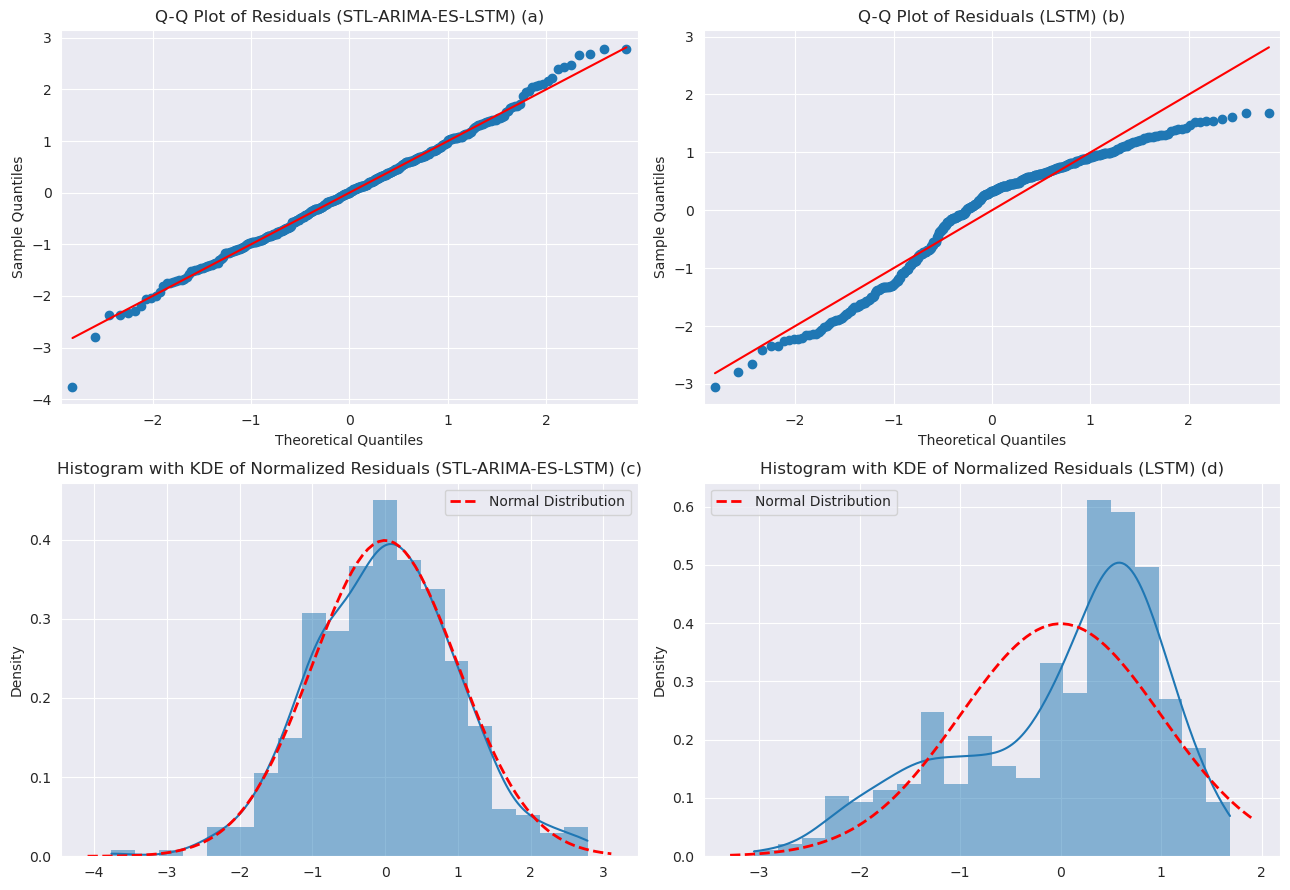

Resumo dos resíduos do modelo STL-ARIMA-ES-LSTM:

Resumo das análises estatísticas:
Shapiro-Wilk Test p-value: 0.5241652451505787 - Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05).
Kolmogorov-Smirnov Test p-value: 0.3439462952550463 - Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05).
Durbin-Watson Statistic: 1.8132724578989212 - Não há evidência de autocorrelação nos resíduos (Durbin-Watson dentro do intervalo 1.5-2.5).
Shapiro-Francia Test p-value: 0.35277587813187883 - Não podemos rejeitar a hipótese nula de que os resíduos seguem uma distribuição normal (p > 0.05).
Ljung-Box Test p-value:       lb_stat     lb_pvalue
1    3.072397  7.963197e-02
2    3.087746  2.135524e-01
3    9.403378  2.438179e-02
4   11.890596  1.818364e-02
5   17.379863  3.832972e-03
6   17.795934  6.762924e-03
7   42.381381  4.390616e-07
8   44.710919  4.174564e-07
9   44.712138  1.042937e-06
10  44.868335  2.29694

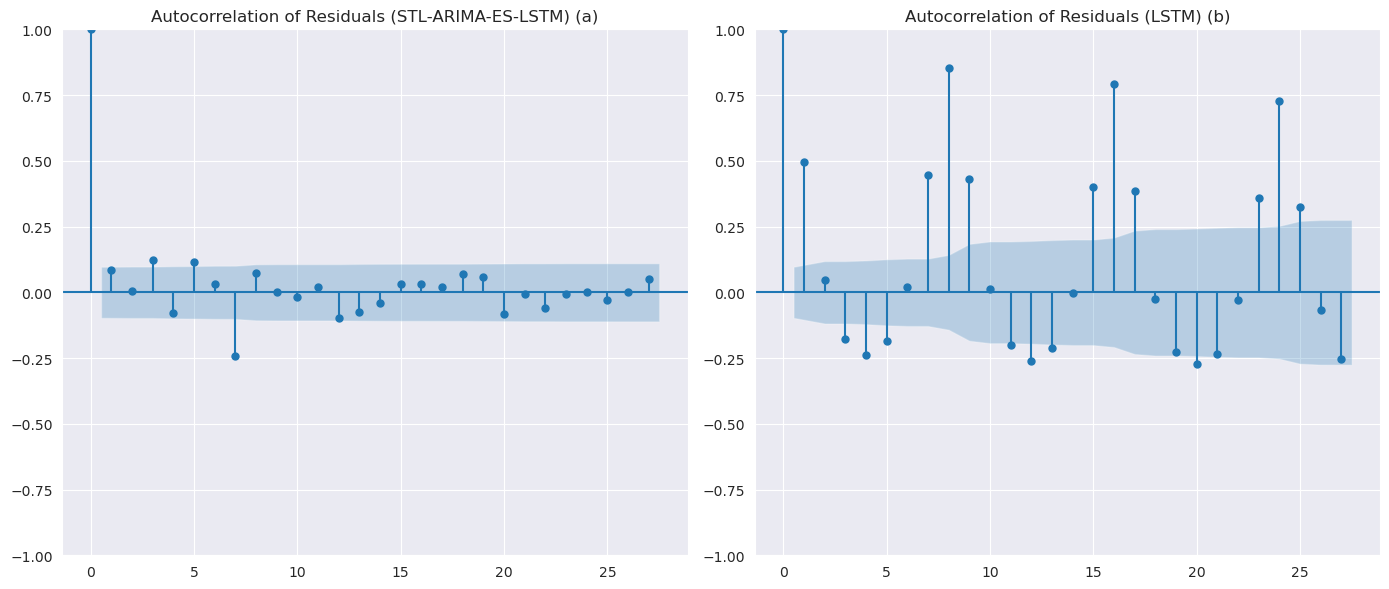

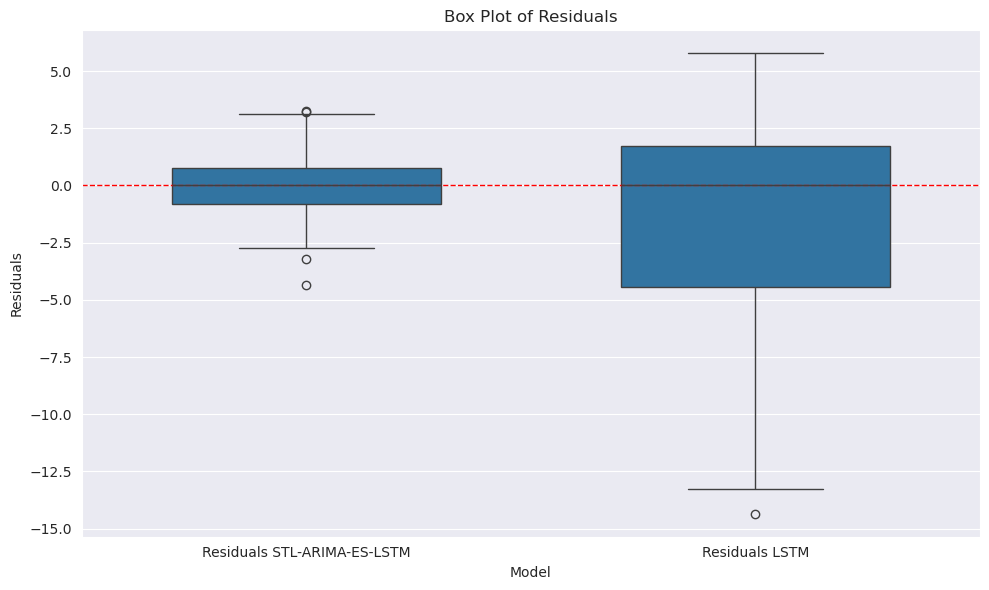

In [48]:
residual_general_summary(hybrid_forecast.flatten(), lstm_forecast.flatten(), target_hybrid.flatten(), target_lstm.flatten(), datetime)